In [2]:
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

### DataSource

In [3]:
class DataSource:
    
    def __init__(self, filename):
        self.df = pd.read_csv(filename)
        
    def data_load_split(self, target=None, ignore=None):
        self.target = target
        self.ignore = ignore
        self.inputs = sorted(set(self.df.columns) - set(self.target) - set(self.ignore))
        
        self.X = self.df[self.inputs]
        self.y = self.df[self.target]
        
        return self.X, self.y
    
    def define_problem(self):
        if self.y.dtypes[0] in ['int64', 'float64'] and self.y.nunique()[0] == 2:
            self.problem = "Binary"
        elif self.y.dtypes[0] in ['object', 'bool']:
            self.problem = "Classification"
        else:
            self.problem = "Regression"
    
        return self.problem
    
    def data_preprocess(self, X, y, problem="Regression"):

        # Data type detection
        numerical_ix = self.X.select_dtypes(include=['int64', 'float64']).columns
        categorical_ix = self.X.select_dtypes(include=['object', 'bool']).columns

        # Data transform
        num_transform = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])
        cat_transform = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value="Missing")),
            ('oh_encoder', OneHotEncoder(sparse=False))
        ])

        transform_x = ColumnTransformer(transformers=[
            ('num', num_transform, numerical_ix),
            ('cat', cat_transform, categorical_ix)
        ])
        
        if problem == "Regression" or "Binary":
            transform_y = ColumnTransformer(transformers=[
                ('num', Normalizer(), y.columns)
            ])
        else:
            transform_y = ColumnTransformer(transformers=[
                ('cat', cat_transform, y.columns)
            ])
            
        trans_X = transform_x.fit_transform(self.X)
        trans_y = transform_y.fit_transform(self.y)

        return trans_X, trans_y
    
    def train_val_split(self, X, y, ratio=0.2, random_state=42):
        return train_test_split(X, y, test_size=ratio, random_state=random_state)

In [6]:
filename="./data/titanic_train.csv"
ds = DataSource(filename)

X, y = ds.data_load_split(target=['Survived'], 
                          ignore=["Name", "Cabin", "Ticket"])

X_train, X_val, y_train, y_val = ds.train_val_split(X, y, ratio=0.2, random_state=42)
problem = ds.define_problem()
trans_X_train, trans_y_train = ds.data_preprocess(X_train, y_train, problem=problem)
trans_X_val, trans_y_val = ds.data_preprocess(X_val, y_val, problem=problem)

### MLP

In [7]:
class MLP:
    
    def __init__(self, X, y, problem="Regression"):
        tf.random.set_seed(42)
        self.problem = problem
        self.X = X
        self.y = y
        
    def build_structure(self, max_hidden_layers=1, units=[16], use_all=False):
        self.structures = []
        self.structures_info = []
        if use_all:
            self.max_hidden_layers = 3
            self.units = [16, 32, 64, 128, 256]
        else:
            self.max_hidden_layers = max_hidden_layers
            self.units = units
    
        grid = [np.arange(self.max_hidden_layers)+1, self.units]
        for param_tuple in itertools.product(*grid):
            structure_param = {'hidden_layers': param_tuple[0],
                                'units': param_tuple[1]}

            # input layer
            model = keras.Sequential()
            model.add(keras.layers.Dense(16, input_shape=(self.X.shape[1],)))

            # hidden layer block
            for _ in range(structure_param['hidden_layers']):
                model.add(keras.layers.Dense(structure_param['units'], activation='relu'))

            # output layer
            if problem == 'Regression':
                model.add(keras.layers.Dense(1))
            elif problem == 'Binary':
                model.add(keras.layers.Dense(1, activation='sigmoid'))
            else:
                model.add(keras.layers.Dense(self.y.shape[1], activation='softmax'))

            self.structures.append(model)
            self.structures_info.append(structure_param)

        return self.structures, self.structures_info
    
    def create_optimizer(self, optimizers=['adam'], lrs=[0.01], use_all=False):
        self.created_optimizers = []
        self.optimizers_info = []
        self.optimizers = optimizers
        self.lrs = lrs

        self.optimizer_classes = {'adadelta': keras.optimizers.Adadelta, 'sgd': keras.optimizers.SGD,
                                  'adam': keras.optimizers.Adam, 'adagrad': keras.optimizers.Adagrad,
                                  'adamax': keras.optimizers.Adamax, 'rmsprop': keras.optimizers.RMSprop}

        if use_all:
            self.lrs = [0.001, 0.01, 0.02, 0.1]
            opt_grid = [self.optimizer_classes.keys(), self.lrs]    
        else:
            opt_grid = [self.optimizers, self.lrs]

        for opt_tuple in itertools.product(*opt_grid):
            opt_param = {
                'optimizer_name': opt_tuple[0],
                'lr': opt_tuple[1]
            }

            opt_class = self.optimizer_classes.get(opt_param['optimizer_name'])
            self.created_optimizers.append(opt_class(opt_param['lr']))
            self.optimizers_info.append(opt_param)

        return self.created_optimizers, self.optimizers_info
    
    def _compile_model(self):
        if self.problem == "Regression":
            self.loss = keras.losses.MSE
            self.metrics = ['MSE', 'MAE']
        elif self.problem == "Binary":
            self.loss = keras.losses.binary_crossentropy
            self.metrics = ['accuracy']
        else:
            self.loss = keras.losses.categorical_crossentropy
            self.metrics = ['accuracy']

        self.compiled_models = []
        self.compiled_models_info = []

        compile_grid = [zip(self.structures, self.structures_info), zip(self.created_optimizers ,self.optimizers_info)]
        for compile_tuple in itertools.product(*compile_grid):
            compile_param = {'model': compile_tuple[0][0],
                             'optimizer': compile_tuple[1][0]}
            model_info = {'structure_info': compile_tuple[0][1],
                           'optimizer_info': compile_tuple[1][1]}

            model_body = compile_param['model']
            model = keras.models.clone_model(model_body)
            model.compile(optimizer=compile_param['optimizer'],
                               loss=self.loss,
                               metrics=self.metrics)

            self.compiled_models.append(model)
            self.compiled_models_info.append(model_info)

        return self.compiled_models, self.compiled_models_info
    
    def train_models(self, models, X_train, y_train, X_val=None, y_val=None,
                     batch_size=None, epochs=1, verbose=0, callbacks=None,
                     shuffle=True, steps_per_epoch=None):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val

        self.trained_models = []
        self.val_losses = []
        for model in models:
            model.fit(x=self.X_train, y=self.y_train,
                      batch_size=batch_size, epochs=epochs,
                      verbose=verbose, callbacks=callbacks,
                      validation_data=(self.X_val, self.y_val), shuffle=shuffle)
            
            val_loss = model.evaluate(self.X_val, self.y_val, verbose=0)
            self.trained_models.append(model)
            self.val_losses.append(val_loss[0])
            print("{} model is trained. best val loss is : {}".format(model.name, val_loss))
            
        return self.trained_models
    
    
def select_best_model(trained_models, val_losses, models_info):
    best_idx = np.argmin(val_losses)
    best_model = trained_models[best_idx]
    best_model_info = compiled_models_info[best_idx]
    return best_model, best_model_info

In [8]:
mlp = MLP(trans_X_train, trans_y_train, problem=problem)

In [9]:
structures, structures_info = mlp.build_structure(max_hidden_layers=2, units=[16, 32], use_all=True)
created_optimizers, optimizers_info = mlp.create_optimizer(optimizers=['adam', 'adadelta'], lrs=[0.1, 0.2], use_all=True)
compiled_models, compiled_models_info = mlp._compile_model()

In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

trained_models = mlp.train_models(compiled_models,
                                  trans_X_train, trans_y_train, trans_X_val, trans_y_val,
                                  batch_size=64, epochs=10,
                                  callbacks=[callback])

sequential model is trained. best val loss is : [0.6861374797201658, 0.6170009551098377]
sequential model is trained. best val loss is : [0.6907863988974261, 0.45176695319961796]
sequential model is trained. best val loss is : [0.7014110339689846, 0.4393505253104107]
sequential model is trained. best val loss is : [0.6072347183509906, 0.792741165234002]
sequential model is trained. best val loss is : [0.7140624680856124, 0.38108882521489973]
sequential model is trained. best val loss is : [0.5511611622492245, 0.7440305635148042]
sequential model is trained. best val loss is : [0.5375880055919418, 0.7526265520534862]
sequential model is trained. best val loss is : [0.4294868101283139, 0.8223495702005731]
sequential model is trained. best val loss is : [0.31692900633708054, 0.87774594078319]
sequential model is trained. best val loss is : [0.019156033302691465, 0.994269340974212]
sequential model is trained. best val loss is : [0.010769652553933567, 0.9961795606494747]
sequential model i

sequential_3 model is trained. best val loss is : [0.013213287617176104, 0.9952244508118434]
sequential_3 model is trained. best val loss is : [0.29432040294734607, 0.8997134670487106]
sequential_3 model is trained. best val loss is : [0.026620070100673146, 0.9885386819484241]
sequential_3 model is trained. best val loss is : [0.04693430496231807, 0.9828080229226361]
sequential_3 model is trained. best val loss is : [0.02172098434869393, 0.9894937917860553]
sequential_4 model is trained. best val loss is : [0.6930454345464478, 0.5243553008595988]
sequential_4 model is trained. best val loss is : [0.6872243124639408, 0.6246418338108882]
sequential_4 model is trained. best val loss is : [0.6717982297298901, 0.7182425978987583]
sequential_4 model is trained. best val loss is : [0.5602852448806835, 0.7478510028653295]
sequential_4 model is trained. best val loss is : [0.6892640231445845, 0.6074498567335244]
sequential_4 model is trained. best val loss is : [0.6289818397907267, 0.6456542502

sequential_7 model is trained. best val loss is : [0.5250869329161266, 0.775549188156638]
sequential_7 model is trained. best val loss is : [0.43838091242663496, 0.8166189111747851]
sequential_7 model is trained. best val loss is : [0.38279152168503605, 0.8414517669531996]
sequential_7 model is trained. best val loss is : [0.42604190280168197, 0.8194842406876791]
sequential_7 model is trained. best val loss is : [0.019338078238010918, 0.9961795606494747]
sequential_7 model is trained. best val loss is : [0.017352751244062426, 0.9952244508118434]
sequential_7 model is trained. best val loss is : [0.012201155835124017, 0.994269340974212]
sequential_7 model is trained. best val loss is : [0.22609561043875978, 0.9169054441260746]
sequential_7 model is trained. best val loss is : [0.13352466252247377, 0.9503342884431709]
sequential_7 model is trained. best val loss is : [0.09131209324821056, 0.9694364851957975]
sequential_7 model is trained. best val loss is : [0.13536180906647652, 0.960840

sequential_11 model is trained. best val loss is : [0.4247602410685652, 0.8242597898758357]
sequential_11 model is trained. best val loss is : [0.016166758162832365, 0.9952244508118434]
sequential_11 model is trained. best val loss is : [0.01378116385421345, 0.9952244508118434]
sequential_11 model is trained. best val loss is : [0.013450875713607188, 0.9933142311365807]
sequential_11 model is trained. best val loss is : [0.6641810497672874, 0.620821394460363]
sequential_11 model is trained. best val loss is : [0.6849388015645964, 0.6150907354345749]
sequential_11 model is trained. best val loss is : [0.5917873873580834, 0.6628462273161414]
sequential_11 model is trained. best val loss is : [0.4484153263939771, 0.8127984718242598]
sequential_11 model is trained. best val loss is : [0.42384193441452533, 0.8233046800382043]
sequential_11 model is trained. best val loss is : [0.43947167519512015, 0.8013371537726839]
sequential_11 model is trained. best val loss is : [0.018616941772787568, 

In [11]:
for i in range(len(trained_models)):
    print(trained_models[i].optimizer)

In [12]:
best_model, best_model_info = select_best_model(trained_models, mlp.val_losses, compiled_models_info)

In [14]:
best_model.evaluate(trans_X_val, trans_y_val)

1047/1047 [==============================] - 0s 161us/sample - loss: 0.0069 - accuracy: 0.9971


[0.006869971288084512, 0.997134670487106]

In [15]:
best_model_info

{'structure_info': {'hidden_layers': 2, 'units': 64},
 'optimizer_info': {'optimizer_name': 'adam', 'lr': 0.01}}

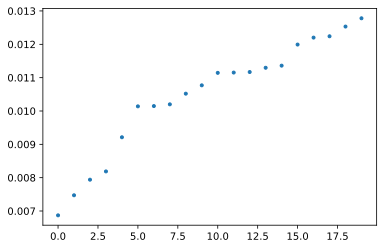

In [35]:
import matplotlib.pyplot as plt
plt.plot(sorted(mlp.val_losses)[:20], '.')